<a href="https://colab.research.google.com/github/edfakie2/Sales-Predictions/blob/main/Copy_of_Sales_Predictions_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
set_config(display='diagram')

In [ ]:
def evaluate_model(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

In [ ]:
path = '/content/sales_predictions.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
df['Item_MRP'] = df['Item_MRP'].astype(int)
df['Item_Outlet_Sales'] = df['Item_Outlet_Sales'].astype(int)
df['Item_Visibility'] = df['Item_Visibility'].astype(float)

In [ ]:
df['Item_Fat_Content'].value_counts()


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')

In [ ]:
df[df.isna().any(axis=1)].shape

(3873, 12)

In [ ]:
Outlet_Size_filter = df['Outlet_Size']
Item_Size_filter = df['Item_Weight']

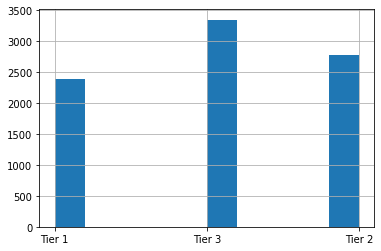

In [ ]:
df['Outlet_Location_Type'].hist();

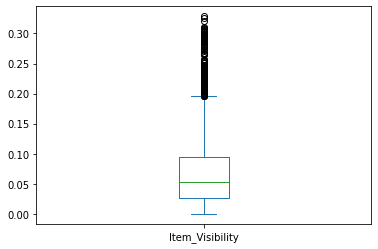

In [ ]:
df['Item_Visibility'].plot(kind='box');

In [ ]:
corr=df.corr()
corr

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027171,-0.011588,0.014122
Item_Visibility,-0.014048,1.000000,-0.001292,-0.074834,-0.128629
Item_MRP,0.027171,-0.001292,1.000000,0.005106,0.567516
Outlet_Establishment_Year,-0.011588,-0.074834,0.005106,1.000000,-0.049134
Item_Outlet_Sales,0.014122,-0.128629,0.567516,-0.049134,1.000000


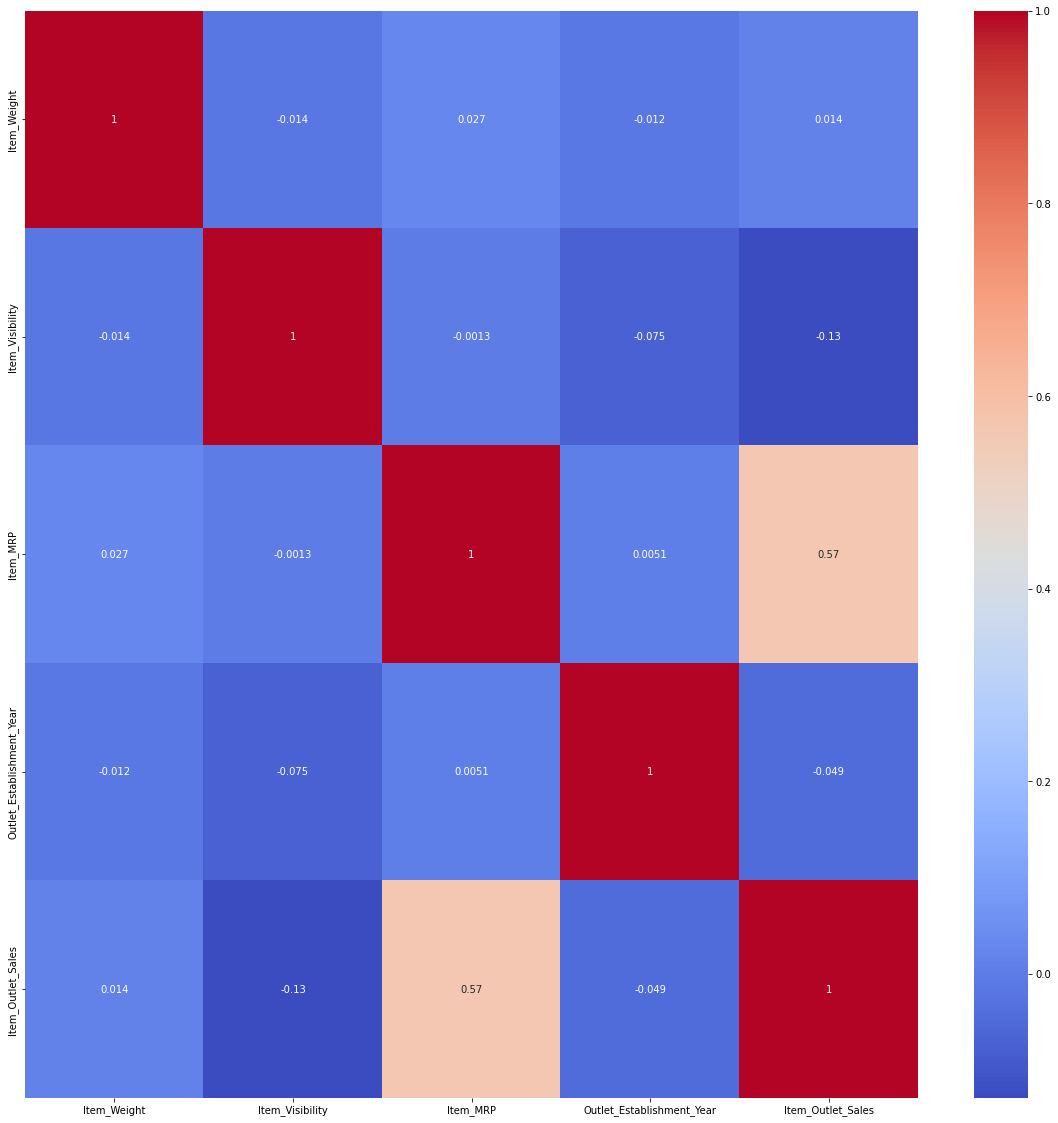

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='coolwarm',annot=True);

In [ ]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)

print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
categorical columns are ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [ ]:
df_num = df[num_columns]

df_num.loc[:, df_num.isna().any()]

,Item_Weight
0,9.300
1,5.920
2,17.500
3,19.200
4,8.930
...,...
8518,6.865
8519,8.380
8520,10.600
8521,7.210


In [ ]:
X_train.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
dtype: bool

In [ ]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

mean_imputer.fit(X_train[num_columns])


X_train.loc[:, num_columns] = mean_imputer.transform(X_train[num_columns])
X_test.loc[:, num_columns] = mean_imputer.transform(X_test[num_columns])


In [ ]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)

In [ ]:
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22cfd1e4d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22cfbe5a50>)])

In [ ]:
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22cfd1e4d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f22cfbe5a50>)])

In [ ]:
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

In [ ]:
dummy = DummyRegressor(strategy='mean')

dummy_pipe = make_pipeline(col_transformer, dummy)

dummy_pipe.fit(X_train, y_train)

train_preds = dummy_pipe.predict(X_train)
test_preds = dummy_pipe.predict(X_test)

evaluate_model(y_train, train_preds)
evaluate_model(y_test, test_preds)

scores: 
MAE: 1,360.22 
MSE: 2,959,443.26 
RMSE: 1,720.30 
R2: 0.00
scores: 
MAE: 1,326.12 
MSE: 2,772,149.22 
RMSE: 1,664.98 
R2: -0.00


In [ ]:
reg = LinearRegression()
reg.fit(X_train_processed, y_train)

LinearRegression()

In [ ]:
train_preds2 = reg.predict(X_train_processed)
test_preds2 = reg.predict(X_test_processed)
evaluate_model(y_train, train_preds2)
evaluate_model(y_test, test_preds2)

scores: 
MAE: 736.57 
MSE: 972,298.79 
RMSE: 986.05 
R2: 0.67
scores: 
MAE: 626,154,041,943.32 
MSE: 60,305,767,616,915,777,307,803,648.00 
RMSE: 7,765,678,825,248.68 
R2: -21857964922229948416.00


In [ ]:
bias = DecisionTreeRegressor(max_depth=None)
bias_pipe = make_pipeline(col_transformer, bias)
bias_pipe.fit(X_train, y_train)
evaluate_model(y_train, bias_pipe.predict(X_train))
evaluate_model(y_test, bias_pipe.predict(X_test))

scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.00 
R2: 1.00
scores: 
MAE: 1,006.43 
MSE: 2,130,421.71 
RMSE: 1,459.60 
R2: 0.23


[Text(0.62101799567421, 0.9930555555555556, 'X[2] <= 0.016\nsquared_error = 2959443.26\nsamples = 6392\nvalue = 2209.475'),
 Text(0.32757042935429065, 0.9791666666666666, 'X[1588] <= 0.5\nsquared_error = 967080.702\nsamples = 3142\nvalue = 1360.108'),
 Text(0.21370980418563706, 0.9652777777777778, 'X[2] <= -0.974\nsquared_error = 886870.151\nsamples = 2756\nvalue = 1521.742'),
 Text(0.06967529174197114, 0.9513888888888888, 'X[3] <= -1.413\nsquared_error = 277017.412\nsamples = 1011\nvalue = 907.584'),
 Text(0.016605981574493188, 0.9375, 'X[2] <= -1.437\nsquared_error = 491295.303\nsamples = 147\nvalue = 1443.102'),
 Text(0.011211710809576987, 0.9236111111111112, 'X[2] <= -1.533\nsquared_error = 162251.974\nsamples = 76\nvalue = 1049.803'),
 Text(0.009464431202889664, 0.9097222222222222, 'X[1564] <= 0.5\nsquared_error = 96322.18\nsamples = 58\nvalue = 958.31'),
 Text(0.008590791399546003, 0.8958333333333334, 'X[787] <= 0.5\nsquared_error = 86738.169\nsamples = 51\nvalue = 916.549'),
 Te

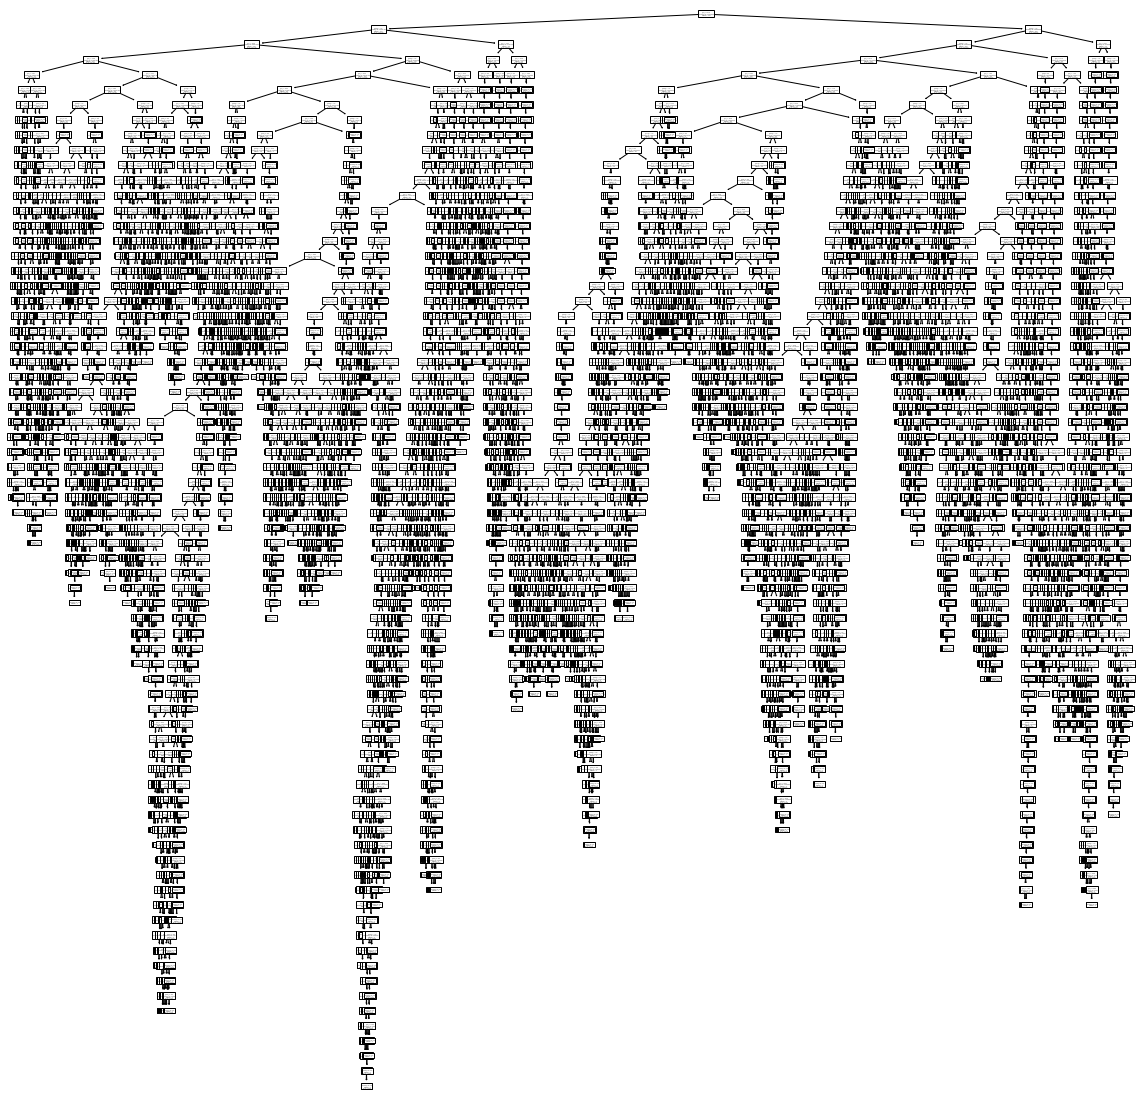

In [ ]:
plt.figure(figsize=(20,20))
plot_tree(bias)

In [ ]:
depths = range(1, bias.get_depth()+1)
scores = pd.DataFrame(columns=['Train','Test'], index=depths)
for depth in depths:
  tree = DecisionTreeRegressor(max_depth=depth)
  tree_pipe = make_pipeline(col_transformer, tree)
  tree_pipe.fit(X_train, y_train)
  train_pred = tree_pipe.predict(X_train)
  test_pred = tree_pipe.predict(X_test)
  r2_train = r2_score(y_train, train_pred)
  r2_test = r2_score(y_test, test_pred)
  scores.loc[depth, 'Train'] = r2_train
  scores.loc[depth, 'Test'] = r2_test

In [ ]:
scores

,Train,Test
1,0.23567,0.231982
2,0.42944,0.435033
3,0.522398,0.525516
4,0.581308,0.586152
5,0.602889,0.596967
...,...,...
67,0.999998,0.213181
68,0.999999,0.217169
69,1.0,0.228979
70,1.0,0.243916


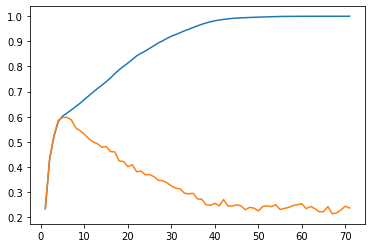

In [ ]:
plt.plot(scores);

In [ ]:
tree.get_depth()

71

In [ ]:
tree.get_n_leaves()

6224

In [ ]:
tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 71,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
best_depth = scores.sort_values(by='Test', ascending=False).index[0]
best_depth

6

In [ ]:
best_tree = DecisionTreeRegressor(max_depth=best_depth)
best_tree_pipe = make_pipeline(col_transformer, best_tree)
best_tree_pipe.fit(X_train, y_train)

evaluate_model(y_train, best_tree_pipe.predict(X_train))
evaluate_model(y_test, best_tree_pipe.predict(X_test))

scores: 
MAE: 750.57 
MSE: 1,140,868.22 
RMSE: 1,068.11 
R2: 0.61
scores: 
MAE: 732.80 
MSE: 1,110,428.06 
RMSE: 1,053.77 
R2: 0.60


In [ ]:
best_tree2 = DecisionTreeRegressor(
 max_depth = 71,
 max_leaf_nodes = 6224, random_state=42
 )
best_tree_pipe2 = make_pipeline(col_transformer, best_tree)
best_tree_pipe2.fit(X_train, y_train)

evaluate_model(y_train, best_tree_pipe2.predict(X_train))
evaluate_model(y_test, best_tree_pipe2.predict(X_test))

scores: 
MAE: 750.57 
MSE: 1,140,868.22 
RMSE: 1,068.11 
R2: 0.61
scores: 
MAE: 732.96 
MSE: 1,110,575.18 
RMSE: 1,053.84 
R2: 0.60


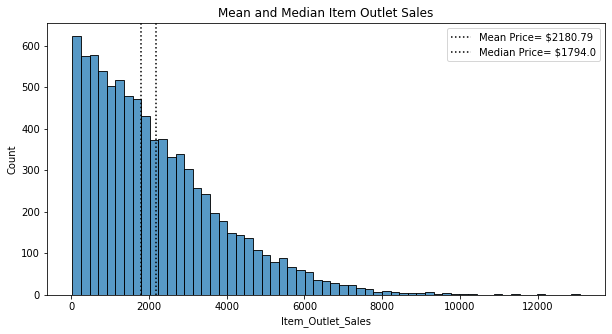

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(data=df, x='Item_Outlet_Sales', ax=ax)
ax.set(title='Mean and Median Item Outlet Sales');

mean_price = df['Item_Outlet_Sales'].mean()
ax.axvline(mean_price,color='k', ls=':', 
           label=f"Mean Price= ${round(mean_price,2)}");

med_price = df['Item_Outlet_Sales'].median()
ax.axvline(med_price,color='k', ls=':', 
           label=f"Median Price= ${round(med_price,2)}");

ax.legend();

In [ ]:
## Using this Tree Regression We were able to get the best result. 